In [1]:
import concurrent.futures
import math
import sys
sys.path.insert(0,'..')
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from doe_xstock.database import SQLiteDatabase
from doe_xstock.utilities import split_lines, write_json

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
DATABASE_FILEPATH = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db'
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)

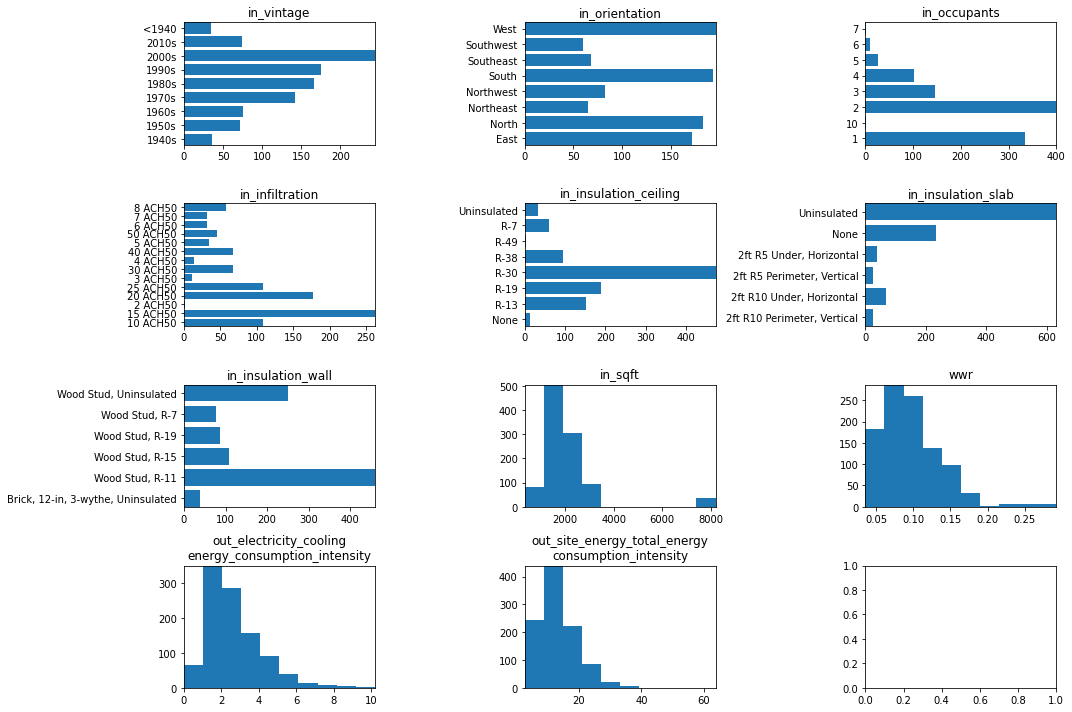

In [3]:
categorical_metadata_fields = [
    'in_vintage',
    'in_orientation',
    'in_occupants',
    'in_infiltration',
    'in_insulation_ceiling',
    # 'in_insulation_floor',
    'in_insulation_slab',
    'in_insulation_wall',
]
numeric_metadata_fields = [
    'in_sqft',
    ('in_window_area_ft_2','/in_wall_area_above_grade_exterior_ft_2','wwr'),
    'out_electricity_cooling_energy_consumption_intensity',  
    # 'out_electricity_heating_energy_consumption_intensity',
    # 'out_electricity_water_systems_energy_consumption_intensity', 
    'out_site_energy_total_energy_consumption_intensity',
]
qoi_metadata_fields = [
    # 'qoi_report_peak_magnitude_timing_hour', 
    # ('qoi_report_peak_magnitude_use_kw','/in_sqft')
]
metadata_fields = categorical_metadata_fields + numeric_metadata_fields + qoi_metadata_fields
metadata_fields_query = [
    c if isinstance(c,str) 
    else f'{c[0]}{c[1]} AS {c[2] if len(c) == 3 else c[0]}' for c in metadata_fields]
metadata_fields = [c if isinstance(c,str) else c[2] if len(c) == 3 else c[0] for c in metadata_fields]
separator = ',\n'
query = f"""
SELECT
    bldg_id,
    {separator.join(metadata_fields_query)}
FROM metadata
WHERE in_resstock_county_id = 'TX, Travis County' 
AND in_geometry_building_type_recs = 'Single-Family Detached'
AND in_vacancy_status = 'Occupied'
"""
metadata = DATABASE.query_table(query).set_index('bldg_id')
# print('Sample:')
# display(metadata.sample(5))
# print('Descriptive statistics:')
# display(metadata.describe(include='all'))

column_limit = 3
row_count = math.ceil(len(metadata.columns)/column_limit)
column_count = min(column_limit,len(metadata.columns))
fig, axs = plt.subplots(row_count,column_count,figsize=(5*column_count,2.5*row_count))

for ax, c in zip(fig.axes,metadata.columns):
    if c not in categorical_metadata_fields:
        ax.hist(metadata[c])
        ax.set_title(split_lines(c,line_character_limit=28,delimiter='_'))
    else:
        plot_data = metadata.groupby(c).size().reset_index(name='count')
        x, y = list(range(plot_data.shape[0])), plot_data['count']
        ax.barh(x,y)
        ax.set_yticks(x)
        ax.set_yticklabels(plot_data[c].to_list())
        ax.set_title(split_lines(c,line_character_limit=28,delimiter='_'))

plt.tight_layout()
plt.show()

In [4]:
# convert discrete variables to continuous
# vintage
# - drop buildings pre-1940s and convert to integer
metadata = metadata[metadata['in_vintage']!='<1940'].copy()
metadata['in_vintage'] = metadata['in_vintage'].str[0:-1].astype(int)

# orientation
# - cosine transformation
order = ['North','Northeast','East','Southeast','South','Southwest','West','Northwest']
metadata['in_orientation'] = metadata['in_orientation'].map(lambda x: order.index(x))
metadata['in_orientation_hour_sin'] = np.sin(2 * np.pi * metadata['in_orientation']/(len(order)-1))
metadata['in_orientation_hour_cos'] = np.cos(2 * np.pi * metadata['in_orientation']/(len(order)-1))
metatada = metadata.drop(columns=['in_orientation'])

# occupants
metadata['in_occupants'] = metadata['in_occupants'].astype(int)

# infiltration
metadata['in_infiltration'] = metadata['in_infiltration'].replace(regex=r' ACH50', value='')
metadata['in_infiltration'] = pd.to_numeric(metadata['in_infiltration'],errors='coerce')
metadata['in_infiltration'] = metadata['in_infiltration'].fillna(0)

# insulation ceiling
metadata['in_insulation_ceiling'] = metadata['in_insulation_ceiling'].replace(regex=r'R-', value='')
metadata['in_insulation_ceiling'] = pd.to_numeric(metadata['in_insulation_ceiling'],errors='coerce')
metadata['in_insulation_ceiling'] = metadata['in_insulation_ceiling'].fillna(0)

# # insulation floor
# metadata['in_insulation_floor'] = metadata['in_insulation_floor'].replace(regex=r'Ceiling R-', value='')
# metadata['in_insulation_floor'] = pd.to_numeric(metadata['in_insulation_floor'],errors='coerce')
# metadata['in_insulation_floor'] = metadata['in_insulation_floor'].fillna(0)

# insulation slab
metadata['in_insulation_slab'] = metadata['in_insulation_slab'].str.split(' ',expand=True)[1]
metadata['in_insulation_slab'] = metadata['in_insulation_slab'].replace(regex=r'R', value='')
metadata['in_insulation_slab'] = pd.to_numeric(metadata['in_insulation_slab'],errors='coerce')
metadata['in_insulation_slab'] = metadata['in_insulation_slab'].fillna(0)

# insulation wall
metadata['in_insulation_wall'] = metadata['in_insulation_wall'].replace(regex=r'.+ R-', value='')
metadata['in_insulation_wall'] = pd.to_numeric(metadata['in_insulation_wall'],errors='coerce')
metadata['in_insulation_wall'] = metadata['in_insulation_wall'].fillna(0)

scaler = MinMaxScaler()
scaled_columns = metadata.columns.tolist()
scaler = scaler.fit(metadata.values)
metadata[metadata.columns.tolist()] = scaler.transform(metadata.values)

In [5]:
metadata

,in_vintage,in_orientation,in_occupants,in_infiltration,in_insulation_ceiling,in_insulation_slab,in_insulation_wall,in_sqft,wwr,out_electricity_cooling_energy_consumption_intensity,out_site_energy_total_energy_consumption_intensity,in_orientation_hour_sin,in_orientation_hour_cos
bldg_id,,,,,,,,,,,,,
40,0.857143,0.142857,0.111111,0.020833,0.612245,0.0,0.578947,1.000000,0.392849,0.113340,0.013966,0.900969,0.801938
209,0.571429,0.857143,0.000000,0.375000,0.387755,0.0,0.578947,0.000000,0.099610,0.455766,0.614610,0.099031,0.801938
384,0.857143,1.000000,0.333333,0.270833,0.612245,0.0,0.578947,0.173150,0.119761,0.289518,0.228994,0.500000,1.000000
478,0.428571,0.000000,0.222222,0.375000,0.612245,0.0,0.368421,0.377956,0.144706,0.189248,0.137474,0.500000,1.000000
637,0.857143,1.000000,0.333333,0.104167,0.612245,0.0,0.578947,0.377956,0.202134,0.159301,0.085952,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
546935,0.571429,0.857143,0.000000,0.166667,0.387755,0.0,0.578947,0.113399,0.065815,0.209475,0.155596,0.099031,0.801938
547375,1.000000,0.285714,0.000000,0.166667,0.612245,0.0,0.789474,0.234935,0.253219,0.168595,0.129412,1.000000,0.356896
548713,0.857143,0.857143,0.111111,0.270833,0.612245,0.0,0.578947,0.296847,0.306133,0.275845,0.080920,0.099031,0.801938


Finished 49/49

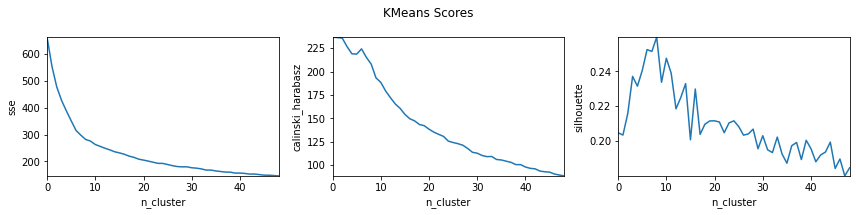

Finished 99/99

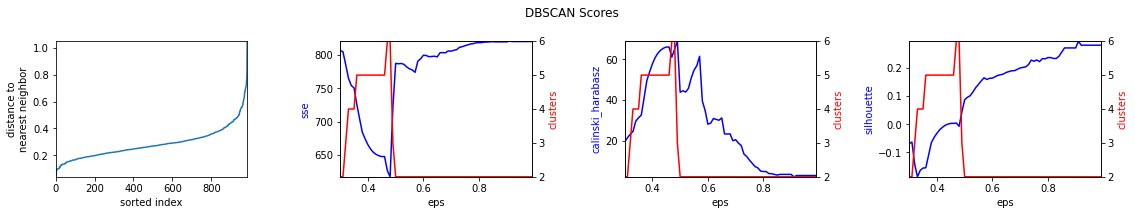

In [6]:
# clustering
x_ = metadata.values

def fit_kmeans(n_clusters):
    result =KMeans(n_clusters,random_state=0).fit(x_)
    scores = {
        'sse':get_sse(x_,result.labels_.tolist()),
        'calinski_harabasz':calinski_harabasz_score(x_,result.labels_),
        'silhouette':silhouette_score(x_,result.labels_)
    }
    return n_clusters, result.labels_.tolist(), scores

def fit_dbscan(eps,min_samples):
    min_samples = int(x_.shape[1]*2) if min_samples is None else min_samples
    result = DBSCAN(eps=eps,min_samples=min_samples).fit(x_)
    
    try:
        scores = {
            'sse':get_sse(x_,result.labels_.tolist()),
            'calinski_harabasz':calinski_harabasz_score(x_,result.labels_),
            'silhouette':silhouette_score(x_,result.labels_)
        }
        return eps, min_samples, result.labels_.tolist(), scores
    except ValueError as e:
        return eps, min_samples, None

def get_sse(x,labels):
    df = pd.DataFrame(x)
    df['label'] = labels
    df = df.groupby('label').apply(lambda gr:
        (gr.iloc[:,0:-1] - gr.iloc[:,0:-1].mean())**2
    )
    sse = df.sum().sum()
    return sse

cluster_result = {}
cluster_result['bldg_id'] = metadata.index.tolist()
algs = ['kmeans','dbscan']

for a in algs:
    cluster_result[a] = {}
    cluster_result[a]['scores'] = {'sse':[],'calinski_harabasz':[],'silhouette':[]}
    cluster_result[a]['labels'] = []

# KMeans
with concurrent.futures.ThreadPoolExecutor() as executor:
    n_clusters = list(range(2,51))
    cluster_result['kmeans']['n_clusters'] = []
    work_order = [n_clusters]
    results = executor.map(fit_kmeans,*work_order)

    for i, r in enumerate(results):
        print(f'\rFinished {i+1}/{len(n_clusters)}',end='')
        if r[2] is None:
            continue
        else:
            cluster_result['kmeans']['n_clusters'].append(r[0])
            cluster_result['kmeans']['labels'].append(r[1])
            cluster_result['kmeans']['scores']['sse'].append(r[2]['sse'])
            cluster_result['kmeans']['scores']['calinski_harabasz'].append(r[2]['calinski_harabasz'])
            cluster_result['kmeans']['scores']['silhouette'].append(r[2]['silhouette'])

row_count = 1
column_count = len(cluster_result['kmeans']['scores'])
fig, axs = plt.subplots(row_count,column_count,figsize=(4*column_count,row_count*3))

for ax, (k, y) in zip(fig.axes,cluster_result['kmeans']['scores'].items()):
    x = list(range(len(y)))
    ax.plot(x,y)
    ax.set_xlabel('n_cluster')
    ax.set_ylabel(k)

fig.suptitle('KMeans Scores')
plt.tight_layout() 
plt.show()

# DBSCAN
with concurrent.futures.ThreadPoolExecutor() as executor:
    cluster_result['dbscan']['knn_distance'] = NearestNeighbors(n_neighbors=2).fit(x_).kneighbors(x_)[0][:,1].tolist()
    cluster_result['dbscan']['eps'] = []
    cluster_result['dbscan']['min_samples'] = []
    work_order = [[],[]]
    step = 0.01
    mini = max(round(min(cluster_result['dbscan']['knn_distance']),1),step)
    maxi = round(max(cluster_result['dbscan']['knn_distance']),1)
    eps = np.arange(mini,maxi,step).tolist()
    work_order[0] = eps
    work_order[1] = [None]*len(eps)
    results = executor.map(fit_dbscan,*work_order)

    for i, r in enumerate(results):
        print(f'\rFinished {i+1}/{len(eps)}',end='')
        if r[2] is None:
            continue
        else:
            cluster_result['dbscan']['eps'].append(r[0])
            cluster_result['dbscan']['min_samples'].append(r[1])
            cluster_result['dbscan']['labels'].append(r[2])
            cluster_result['dbscan']['scores']['sse'].append(r[3]['sse'])
            cluster_result['dbscan']['scores']['calinski_harabasz'].append(r[3]['calinski_harabasz'])
            cluster_result['dbscan']['scores']['silhouette'].append(r[3]['silhouette'])

row_count = 1
column_count = len(cluster_result['dbscan']['scores']) + 1
fig, axs = plt.subplots(row_count,column_count,figsize=(4*column_count,row_count*3))
y = sorted(cluster_result['dbscan']['knn_distance'])
x = list(range(len(y)))
axs[0].plot(x,y)
axs[0].set_ylabel(f'distance to\nnearest neighbor')
axs[0].set_xlabel('sorted index')
x = cluster_result['dbscan']['eps']
y2 = [len(set(l)) for l in cluster_result['dbscan']['labels']]

for j, (score, y1) in enumerate(cluster_result['dbscan']['scores'].items()):
    axs[j+1].plot(x,y1,color='blue')
    axs[j+1].set_xlabel('eps')
    axs[j+1].set_ylabel(score,color='blue')
    ax2 = axs[j+1].twinx()
    ax2.plot(x,y2,color='red')
    ax2.set_ylabel('clusters',color='red')

fig.suptitle('DBSCAN Scores')
plt.tight_layout()
plt.show()

In [7]:
# Using KMeans and silhouette score max as ideal number of cluster
max_score = max(cluster_result['kmeans']['scores']['silhouette'])
ix = cluster_result['kmeans']['scores']['silhouette'].index(max_score)
metadata[scaled_columns] = scaler.inverse_transform(metadata[scaled_columns].values)
labels = cluster_result['kmeans']['labels'][ix]
metadata['label'] = labels
metadata['label'] += 1

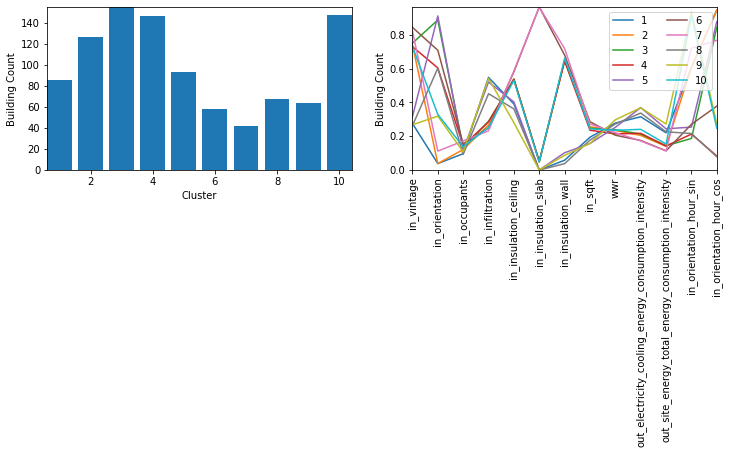

In [8]:
# figures
row_count = 1
column_count = 2
fig, axs = plt.subplots(row_count,column_count,figsize=(6*column_count,3*row_count))

# samples per cluster
plot_data = metadata.groupby(['label']).size().reset_index(name='count')
x, y = plot_data['label'], plot_data['count']
axs[0].bar(x,y)
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Building Count')

# centroid
plot_data = metadata.copy()
plot_data[scaled_columns] = scaler.transform(plot_data[scaled_columns].values)
plot_data = plot_data.groupby(['label']).mean().T
x, y = plot_data.index.tolist(), plot_data.values
axs[1].plot(x,y,label=plot_data.columns.tolist())
# axs[0].set_xlabel()
axs[1].set_ylabel('Building Count')
axs[1].tick_params('x',which='both',rotation=90)
axs[1].legend(ncol=2)
plt.show()

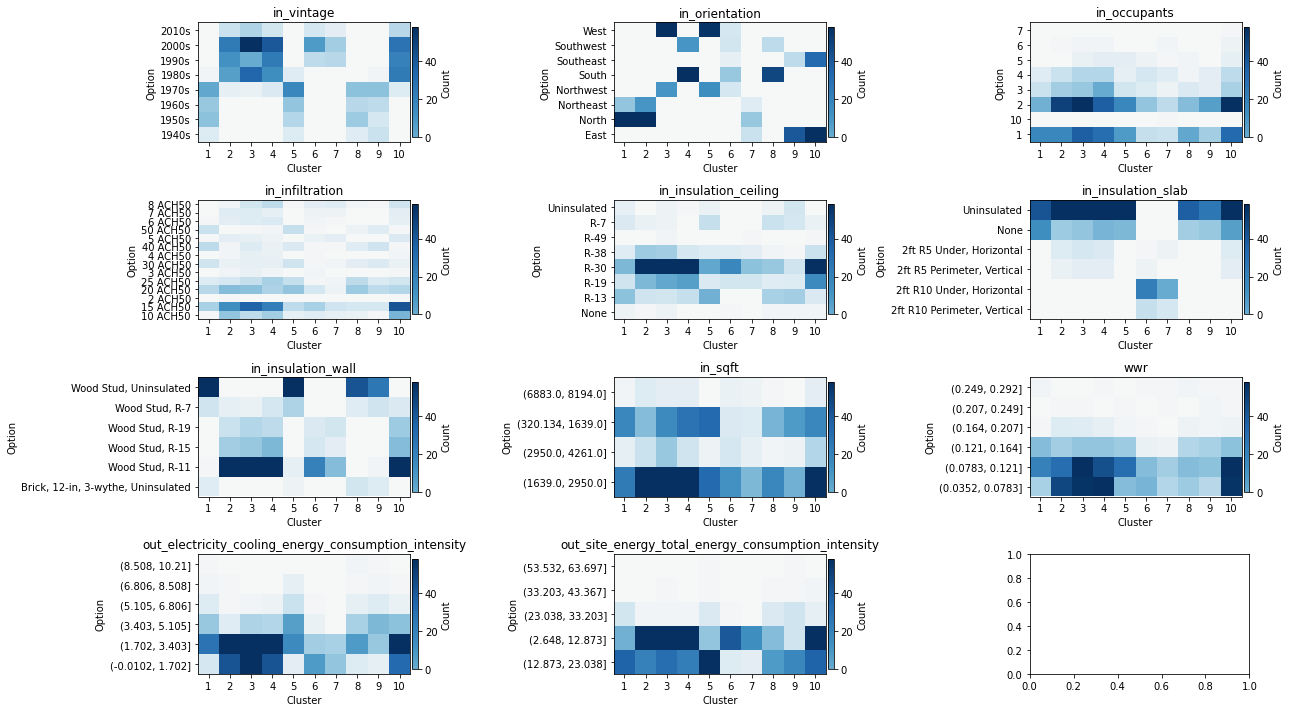

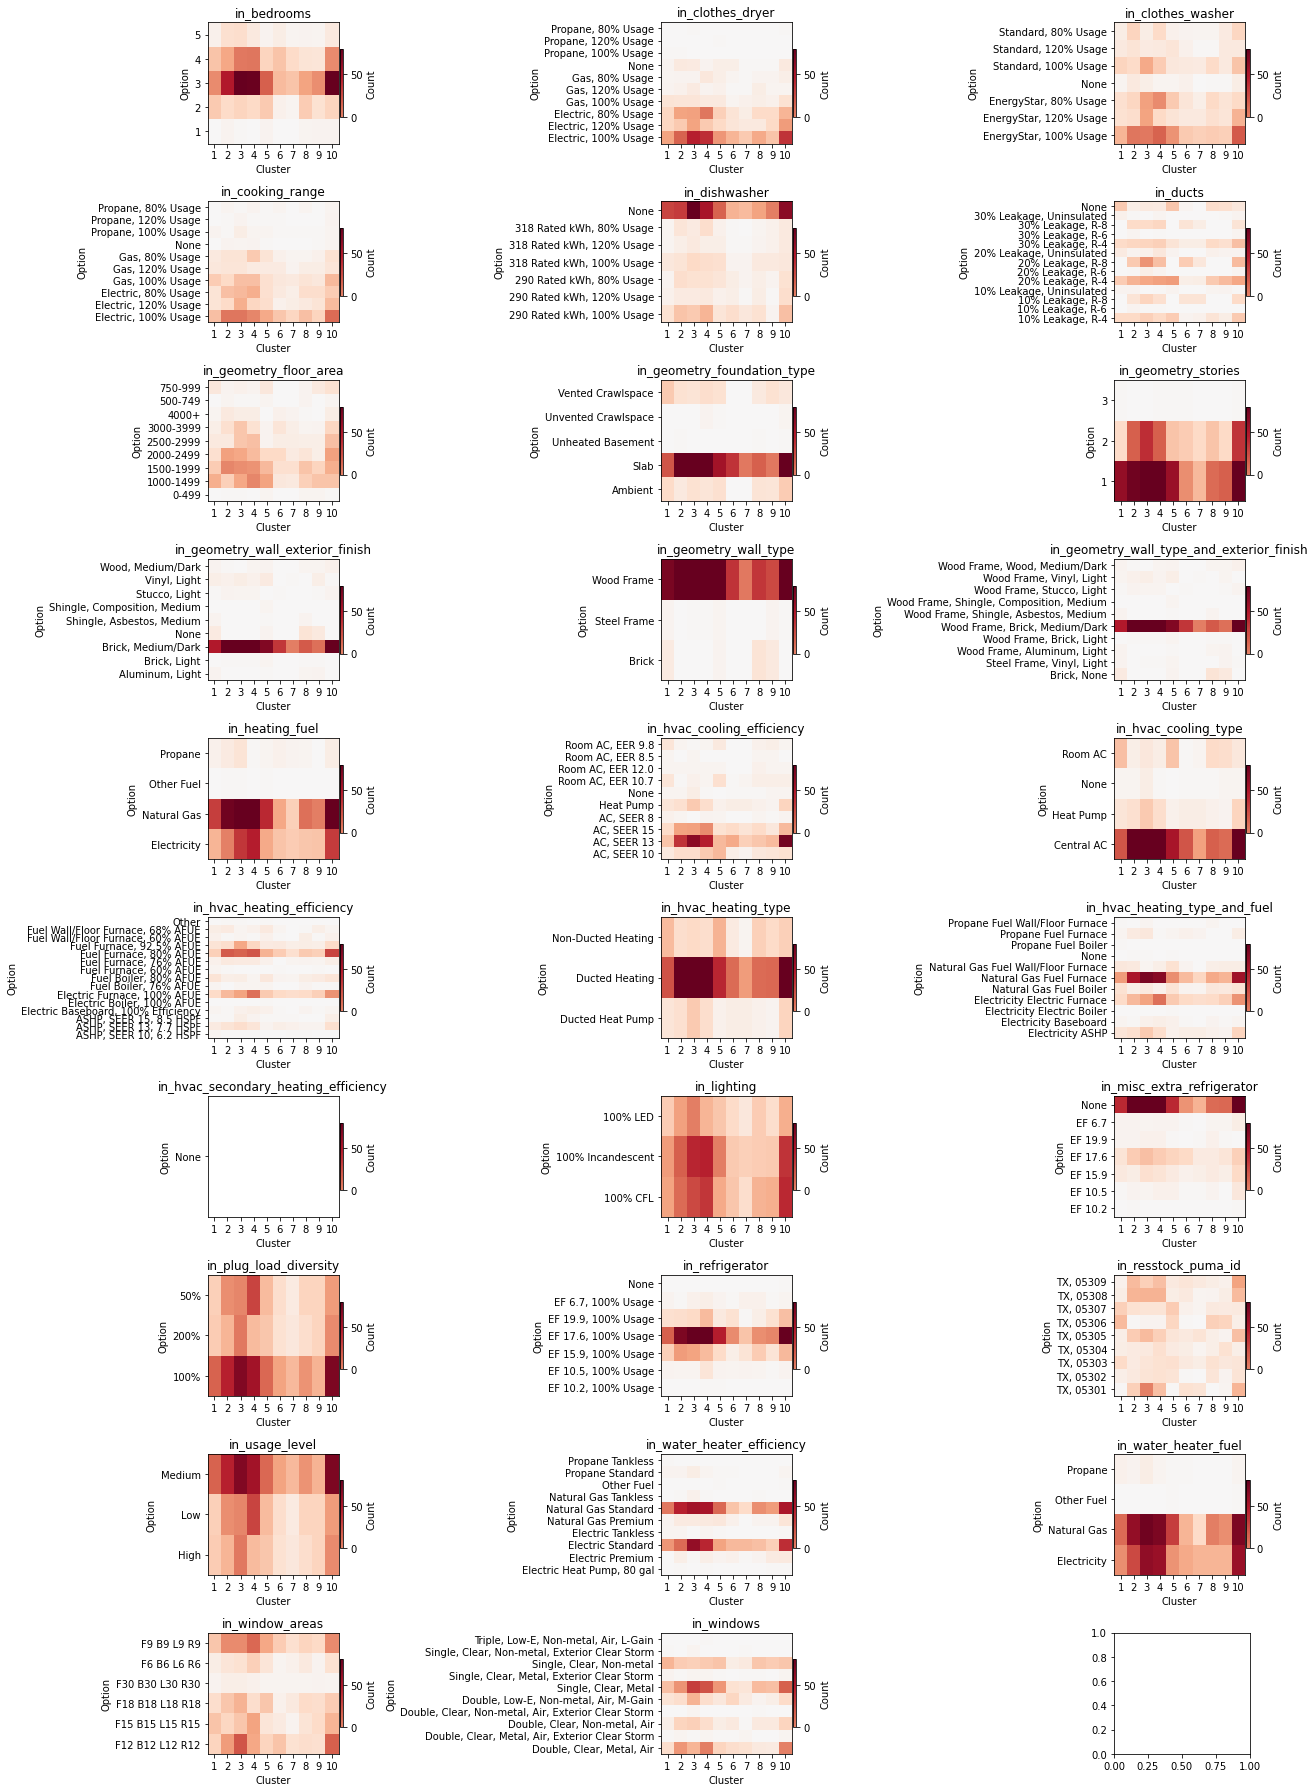

In [9]:
# ground truth distribution
ground_truth_fields = [
    'in_bedrooms', 'in_clothes_dryer', 'in_clothes_washer', 'in_cooking_range',
    'in_dishwasher', 'in_ducts', 
    'in_geometry_floor_area', 'in_geometry_foundation_type', 'in_geometry_stories', 
    'in_geometry_wall_exterior_finish', 'in_geometry_wall_type', 
    'in_geometry_wall_type_and_exterior_finish', 'in_heating_fuel',
    'in_hvac_cooling_efficiency', 'in_hvac_cooling_type', 'in_hvac_heating_efficiency',
    'in_hvac_heating_type', 'in_hvac_heating_type_and_fuel', 
    'in_hvac_secondary_heating_efficiency', 'in_lighting',
    'in_misc_extra_refrigerator',
    'in_plug_load_diversity',  'in_refrigerator', 'in_resstock_puma_id',
    'in_usage_level', 'in_water_heater_efficiency', 
    'in_water_heater_fuel', 'in_window_areas', 'in_windows',
]
ground_truth_query = metadata_fields_query + ground_truth_fields
query = f"""
SELECT
    bldg_id,
    {separator.join(ground_truth_query)}
FROM metadata
"""
metadata = DATABASE.query_table(query)
label_data = pd.DataFrame({'bldg_id':cluster_result['bldg_id'],'label':labels})
label_data['label'] += 1
metadata = metadata.merge(label_data,on='bldg_id',how='inner')
metadata = metadata.set_index('bldg_id')

column_limit = 3
row_count = math.ceil(len(ground_truth_fields)/column_limit)
column_count = min(column_limit,len(ground_truth_fields))

for cmap, columns in zip(['RdBu','RdBu_r'], [metadata_fields,ground_truth_fields]):
    row_count = math.ceil(len(columns)/column_limit)
    column_count = min(column_limit,len(columns))
    fig, axs = plt.subplots(row_count,column_count,figsize=(6*column_count,2.5*row_count))
    divnorm = colors.TwoSlopeNorm(vcenter=0)

    for ax, c in zip(fig.axes,columns):
        plot_data = metadata.copy()

        if pd.api.types.is_numeric_dtype(metadata[c]):
            plot_data[c] = pd.cut(plot_data[c],6)
            plot_data[c] = plot_data[c].astype(str)
        else:
            pass

        plot_data = plot_data[['label',c]].groupby(['label',c]).size().reset_index(name='count')
        plot_data = plot_data.pivot(index=c,columns='label',values='count')
        plot_data = plot_data.fillna(0)
        x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
        _ = ax.pcolormesh(x,y,z,shading='nearest',norm=divnorm,cmap=cmap,edgecolors='white',linewidth=0)
        _ = fig.colorbar(cm.ScalarMappable(cmap=cmap,norm=divnorm),ax=ax,orientation='vertical',label='Count',fraction=0.025,pad=0.01)
        ax.tick_params('x',which='both',rotation=0)
        ax.set_ylabel('Option')
        ax.set_xlabel('Cluster')
        ax.set_title(c)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.tight_layout()
    plt.show()

In [31]:
# select buildings
building_count = 100
building_data = pd.DataFrame({'bldg_id':cluster_result['bldg_id'],'label':labels})
building_data['count'] = building_data.groupby('label')['label'].transform('count')
building_data = building_data.sample(n=building_count,weights=building_data['count'],random_state=0)
write_json('../data/neighborhoods/travis_county.json',building_data['bldg_id'].tolist())

In [10]:
# standardize
# data = metadata.copy()
# pca_explained_variance = 0.95
# scaler = StandardScaler()
# x = data.values
# scaler = scaler.fit(x)
# x = scaler.transform(x)
# data[data.columns.tolist()] = x

# # fit pca
# pca = PCA(n_components=pca_explained_variance,svd_solver='full')
# pca = pca.fit(x)